In [1]:
import gc
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense, Dropout
from keras import optimizers, regularizers, losses
import os
import statsmodels.api as sm
from scipy import stats
import copy
import matplotlib
import pickle
import random
from matplotlib import pyplot as plt
import matplotlib as mpl
import re
from statsmodels.stats import multitest

%matplotlib inline
import seaborn as sns

from functools import reduce
mpl.rcParams['font.family'] = 'Times New Roman'

import plotting_functions
from geneset_plotting_functions import get_geneset_cats

Using TensorFlow backend.


In [3]:
path_to_gs_data = "../../DATA/geneset_data/"
path_to_final_genes = "../../Pipeline_Outputs_Submitted/gene_rankings/"
path_to_ge_data = "../../DATA/MTL_data/"
path_to_gws = "../../Pipeline_Outputs_Submitted/gene_rankings/MTL/gene_scores_for_samples.txt"
path_to_cleaned_phenotypes = "../../DATA/MTL_data/merged_phenotypes.csv"
saved_interactions_path = "../../Pipeline_Outputs_Submitted/gene_rankings/"

In [4]:
tab20cmap=plt.cm.tab20
cmaplist = [tab20cmap(i) for i in range(tab20cmap.N)]

SIG = .05
# set to true if computing IG interaction values for the first time 
compute_new=False
phenotypes = ["CERAD","PLAQUES","ABETA_IHC","BRAAK","TANGLES", "TAU_IHC"]

### Load data

In [5]:
with h5py.File(path_to_ge_data + "ACT_MSBBRNA_ROSMAP.h5", 'r') as hf:
    print(list(hf.keys()))
    ge = hf["ge"][:]
    gene_symbols = hf["gene_symbols"][:].astype(str)

IG_samples = np.loadtxt(path_to_gws)


num_components=500
with h5py.File(path_to_ge_data + "ACT_MSBBRNA_ROSMAP_PCA.h5", 'r') as hf:
    print(list(hf.keys()))
    Y = hf["labels"][:]
    labels_names= hf["labels_names"][:].astype(str)

labels_df = pd.DataFrame(Y, columns=labels_names.astype(str), dtype="str")

['ge', 'gene_symbols', 'labels', 'labels_names']
['PCA_components_', 'ge_transformed', 'gene_symbols', 'labels', 'labels_names']


In [6]:
merged_phenotypes = pd.read_csv(path_to_cleaned_phenotypes)
    
for var in phenotypes:
    merged_phenotypes["%s_percentile"%var] = labels_df["%s"%var].astype(float).rank()/len(labels_df)
    
merged_phenotypes["neuropath_score"] = np.nanmean(merged_phenotypes[["%s_percentile"%var for var in phenotypes]],axis=1)

In [7]:
CONSENSUS_SCORES = pd.read_csv(path_to_final_genes + "MTL/all-related.rnk", sep="\t", header=None, names=["gene", "score"]).sort_values("score", ascending=False).reset_index(drop=True)
CONSENSUS_SCORES["abs_score"] = CONSENSUS_SCORES["score"].apply(lambda x: (x-.5)*2 if x>=.5 else (.5-x)*2)
SORTED_MDAD_GENES = CONSENSUS_SCORES.sort_values("abs_score",ascending=False)["gene"].values

In [8]:
def calculate_interaction_main_effect_phen(x1,x2,y):
    TEMP = np.column_stack([x1, x2, x1*x2])
    TEMP2 = sm.add_constant(TEMP)
    est = sm.OLS(y, TEMP2)
    est2 = est.fit()
    #main effect for x1
    main_effect_phen_pval = est2.pvalues[2]
    main_effect_phen_coeff = est2.params[2]
    
    interaction_pval = est2.pvalues[3]
    interaction_coeff = est2.params[3]
    return interaction_coeff, interaction_pval, main_effect_phen_coeff, main_effect_phen_pval

### COMPUTING INTERACTIONS

In [9]:
to_check_cats = ["sex_m", "sex_m_permuted"]
interaction_phen = "sex_m"

def get_shuffle_phen(df, phen):
    labels = copy.copy(df[phen].values)
    np.random.shuffle(labels)
    df[phen+"_permuted"] = labels
    
get_shuffle_phen(merged_phenotypes, "sex_m")

In [10]:
interaction_coefs = {}
interaction_pvals = {}
main_effect_phen_coefs =  {}
main_effect_phen_pvals = {}

for i,phen in enumerate(to_check_cats):
#     print(phen)
    if compute_new:
        interaction_coefs[phen] = np.zeros(len(gene_symbols))
        interaction_pvals[phen] = np.ones(len(gene_symbols))
        main_effect_phen_coefs[phen] = np.zeros(len(gene_symbols))
        main_effect_phen_pvals[phen] = np.ones(len(gene_symbols))

        to_check_idx = np.where(~np.isnan(merged_phenotypes[phen].values))[0]

        for j,g in enumerate(gene_symbols):
            if j %1000==0:
                print(j)
            interaction_coefs[phen][j], interaction_pvals[phen][j], main_effect_phen_coefs[phen][j], main_effect_phen_pvals[phen][j] = calculate_interaction_main_effect_phen(ge[to_check_idx][:,j], merged_phenotypes[phen].values[to_check_idx], IG_samples[to_check_idx][:,j])

        np.savetxt(saved_interactions_path+"interaction_coefs_%s.txt"%phen, interaction_coefs[phen])
        np.savetxt(saved_interactions_path+"interaction_pvals_%s.txt"%phen, interaction_pvals[phen])
    else:
        interaction_coefs[phen] = np.loadtxt(saved_interactions_path+"interaction_coefs_%s.txt"%phen)
        interaction_pvals[phen] = np.loadtxt(saved_interactions_path+"interaction_pvals_%s.txt"%phen)

In [11]:
fdr_interaction_pvals = {}
for key in interaction_pvals.keys():
    fdr_interaction_pvals[key] = multitest.fdrcorrection(interaction_pvals[key], alpha=SIG, method='indep', is_sorted=False)[1]

Text(0.5, 0.98, 'Distribution of sex-interaction p-values across genes')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


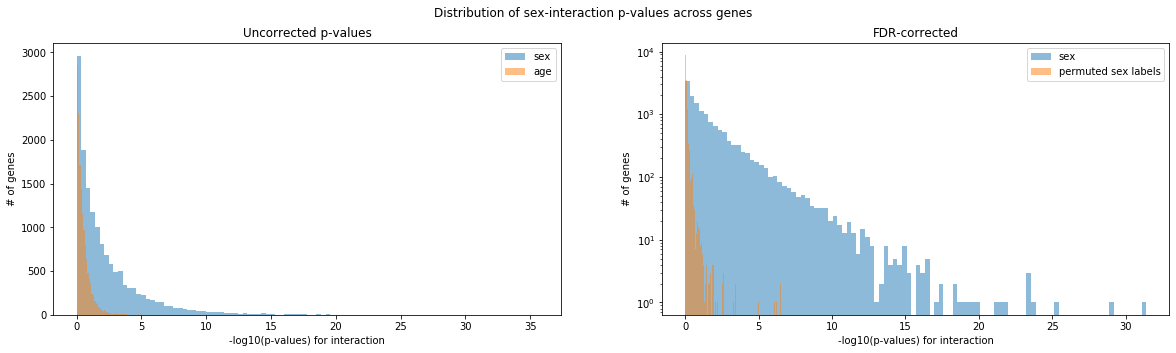

In [12]:
fig,ax = plt.subplots(1,2,figsize=(20,5))


ax[0].hist(-np.log10(interaction_pvals["sex_m"]), bins=100,alpha=.5)
ax[0].hist(-np.log10(interaction_pvals["sex_m_permuted"]), bins=100, alpha=.5)
ax[0].legend(["sex","age","permuted sex labels"])
ax[0].set_xlabel("-log10(p-values) for interaction")
ax[0].set_ylabel("# of genes")
ax[0].set_title("Uncorrected p-values")

ax[1].hist(-np.log10(fdr_interaction_pvals["sex_m"]), bins=100,alpha=.5, log=True)
ax[1].hist(-np.log10(fdr_interaction_pvals["sex_m_permuted"]), bins=100, alpha=.5, log=True)
ax[1].legend(["sex", "permuted sex labels"])
ax[1].set_xlabel("-log10(p-values) for interaction")
ax[1].set_ylabel("# of genes")
ax[1].set_title("FDR-corrected")

fig.suptitle("Distribution of sex-interaction p-values across genes")


### GENE SET ENRICHMENT

In [13]:
gene_symbols = np.loadtxt(path_to_gs_data + "genesymbols.txt", dtype="str")


gmt_locations = {"REACTOME": path_to_gs_data + 'c2.all.v7.0.symbols_JustR.gmt',
                "KEGG": path_to_gs_data + 'c2.all.v7.0.symbols_JustK.gmt',
                "HALLMARK": path_to_gs_data+ 'h.all.v7.0.symbols.gmt'}
for gset in ["mathys_celltypes", "sara_modules", "ben_modules", "mathys_microglia", "patrick_microglia", "olah_microglia"]:
    gmt_locations[gset] = path_to_gs_data + "%s/processed/gene_set.gmt"%gset
    
gset="REACTOME"
gmt, category_to_geneset, geneset_to_category = get_geneset_cats(gset, path_to_gs_data, gmt_locations)
cmapper = {}

category_genes = {}
for category in category_to_geneset.keys():
    genes_in_cat = np.array([])
    genesets = category_to_geneset[category]
    for geneset in genesets:
        if geneset in gmt["names"].values:
            genes_in_cat = np.append(genes_in_cat, gmt[gmt["names"]==geneset]["genes"].values[0])
    category_genes[category] = np.unique(genes_in_cat)

In [ ]:
FISHER_S = {}
FISHER_P = {}
topxs = [len(gene_symbols),100]

for topx in topxs:
    print(topx)

    Fisher_test_stats = np.zeros(len(list(category_genes.keys())))
    Fisher_pvals = np.ones(len(list(category_genes.keys())))

    interaction_genes = gene_symbols[np.where(fdr_interaction_pvals[interaction_phen]<SIG)[0]]
    interaction_genes = np.intersect1d(interaction_genes, SORTED_MDAD_GENES[:topx+1])

    for j,gset_cat in enumerate(list(category_genes.keys())):
        gset_genes = category_genes[gset_cat]

        fisher_matrix = np.zeros([2,2])
        fisher_matrix[0,0] = len(np.intersect1d(interaction_genes, gset_genes))
        fisher_matrix[0,1] = len(np.intersect1d(interaction_genes, np.setdiff1d(gene_symbols.astype(str), gset_genes)))
        fisher_matrix[1,0] = len(np.intersect1d(gset_genes, np.setdiff1d(gene_symbols.astype(str), interaction_genes)))
        fisher_matrix[1,1] = len(np.setdiff1d(gene_symbols.astype(str), np.union1d(interaction_genes, gset_genes)))

        Fisher_test_stats[j], Fisher_pvals[j] = stats.fisher_exact(fisher_matrix)
    
    FISHER_S[topx] = Fisher_test_stats
    FISHER_P[topx] = Fisher_pvals

14591


In [ ]:
interaction_genes = gene_symbols[np.where(fdr_interaction_pvals[interaction_phen]<SIG)[0]]

In [ ]:
if gset == "mathys_microglia":
    set_from_last_figure = ["Cluster 3 (early)", "Cluster 7 (early)", "Cluster 6 (late)"]
elif gset == "REACTOME":
    set_from_last_figure =  ['REACTOME_METABOLISM_OF_RNA',
     'Metabolism',
     'Immune System',
     'REACTOME_CELL_CELL_COMMUNICATION',
     'REACTOME_CELLULAR_RESPONSES_TO_EXTERNAL_STIMULI',
     'Metabolism of proteins',
     'Signal Transduction',
     'REACTOME_TRANSPORT_OF_SMALL_MOLECULES',
     'REACTOME_HEMOSTASIS',
     'REACTOME_GENE_EXPRESSION_TRANSCRIPTION',
     'REACTOME_DEVELOPMENTAL_BIOLOGY',
     'REACTOME_DISEASE',
     'REACTOME_MUSCLE_CONTRACTION',
     'REACTOME_CHROMATIN_ORGANIZATION']
elif gset == "KEGG":
    set_from_last_figure = ['Immune disease',
     'Immune system',
     'Carbohydrate metabolism',
     'Translation',
      'Cell motility',
     'Cardiovascular disease',
      'Signaling molecules and interaction',
     'Cancer: specific types',
     'Signal transduction',
     'Cell growth and death',
    'Cellular community - eukaryotes']
else:
    set_from_last_figure = []

for i,elt in enumerate(set_from_last_figure):
    cmapper[elt] = cmaplist[i]

# if there's not a  lot of categories, add them to the color dict and we can display more    
if len(category_genes.keys()) < 10:
    for cat in category_genes.keys():
        if cat not in cmapper.keys():
            cmapper[cat]= cmaplist[len(cmapper.keys())]


In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,10), sharey="row")


for plt_i, topx in enumerate(topxs):
    
    gs_sigs = FISHER_P[topx]
    numsig_allgenes = np.sum(gs_sigs < SIG)
    sig_all_genes = np.argsort(gs_sigs)[:numsig_allgenes]

    xlabs = [""]
    for loc,i in enumerate(sig_all_genes):
        cat = list(category_genes.keys())[i]

        if cat in cmapper.keys():
            color_to_plot = cmapper[cat]
        else:
            c_idx = len(cmapper.keys())
            cmapper[cat] = cmaplist[c_idx]
            color_to_plot = cmapper[cat]        

        ax[plt_i].bar(loc, -np.log10(gs_sigs[i]), color=color_to_plot)
        xlabs.append(cat)
    
    ax[plt_i].plot(np.arange(-.5,len(sig_all_genes)+.5), [-np.log10(SIG)]*(len(sig_all_genes)+1), color="#aaaaaa", linestyle="--")

    ax[plt_i].spines['right'].set_visible(False)
    ax[plt_i].spines['top'].set_visible(False)
    ax[plt_i].set_facecolor('None')
    # ax.set_ylim(0,3)


In [ ]:
toplot_lim =100

fig,axes = plt.subplots(2,figsize=(30,8), sharey="row", sharex="col", 
                        gridspec_kw ={"height_ratios":[8,6]})

gene_idxs_for_plot = [list(gene_symbols).index(x) for x in SORTED_MDAD_GENES[:toplot_lim]]

# --------------------- gene geneset heatmap ----------------------------------#
for col_idx,key in enumerate(cmapper):
    to_plot_genes_in_cat = np.intersect1d(SORTED_MDAD_GENES[:toplot_lim],np.intersect1d(gene_symbols,category_genes[key]))
    gene_idxs = np.array([list(SORTED_MDAD_GENES[:toplot_lim]).index(x) for x in to_plot_genes_in_cat])

    if len(gene_idxs)>0:
        for j in gene_idxs:
            if fdr_interaction_pvals[interaction_phen][gene_idxs_for_plot][j] < SIG:
                axes[1].scatter(j+.5, len(cmapper)-col_idx, color = cmapper[key], marker="s", s=200)
            else:
                axes[1].scatter(j+.5, len(cmapper)-col_idx, color = cmapper[key], marker="x", s=200)
                
for x in range(0, toplot_lim, 25):
    axes[1].axvline(x, alpha=.3, color="gray")    
    
#--------------------- gene - interaction value bar chart ----------------------#
    
axes[0].bar(np.arange(toplot_lim), -np.log10(fdr_interaction_pvals[interaction_phen][gene_idxs_for_plot]), align='edge', width=.8,color="#cccccc")
axes[0].plot([0,toplot_lim], [-np.log10(SIG)]*2, color="#aaaaaa", linestyle="--")
axes[0].set_xlim(0,toplot_lim)

#-------------------- formatting -----------------------------------------------#

axes[1].spines['top'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].set_facecolor('None')

axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].set_facecolor('None')

    
fig.tight_layout()


In [ ]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=c, lw=8) for c in list(cmapper.values())]
ax = plt.subplot()  #create the axes 
ax.set_axis_off()  #turn off the axis 
num_cols = int(np.ceil((len(cmapper.keys()) + 1)/10))
num_cols = 1

ax.legend(custom_lines,  list(cmapper.keys()), frameon=False, ncol=num_cols)
plt.show() 

In [ ]:
# PRINT LABELS
# for elt in list(cmapper.keys()):
#     print(elt)

### Showing top interacting genes

In [ ]:
top_gene_idxs = [list(gene_symbols).index(x) for x in SORTED_MDAD_GENES[:100]]
top_interaction_idxs = np.array(top_gene_idxs)[np.argsort(fdr_interaction_pvals[interaction_phen][top_gene_idxs])[:6]]
genes_to_check = gene_symbols[top_interaction_idxs]

In [ ]:
def gene_member_mx_cmapper(gene_list, category_genes, cmaplist, preset_colormap=None):
    gene_list = gene_symbols[top_interaction_idxs]
    cat_hits_df = pd.DataFrame(pd.DataFrame(0, columns=category_genes.keys(), index=gene_list))

    for cat in category_genes.keys():
        gs = category_genes[cat]
        for id_hit in np.where(np.in1d(gene_list,gs))[0]:
            cat_hits_df.at[gene_list[id_hit], cat]=1

    non_zero_cols = cat_hits_df.columns[cat_hits_df.sum(axis=0) > 0]
    
    if preset_colormap:
        gsea_cats = list(preset_colormap.keys())
    else:
        gsea_cats = np.array([]) 
        
    cat_hits_df = (cat_hits_df>0).astype(int)
    non_gsea_cats = np.setdiff1d(non_zero_cols, gsea_cats)
    non_gsea_sorted_cats = cat_hits_df[non_gsea_cats].sum(axis=0).sort_values().index
    cols_appearing_in_plot = np.append(gsea_cats,non_gsea_sorted_cats)[::-1]
    cat_hits_df_toplot=cat_hits_df[cols_appearing_in_plot]

    
    ### ADD TO OLD COLORMAPPER OR CREATE NEW COLORMAPPER
    if preset_colormap:
        new_color_mapper = copy.copy(preset_colormap)
        set_colors_from_before = list(new_color_mapper.keys())
    else:
        new_color_mapper = {}
        set_colors_from_before = np.array([])
    
    missed_top_cats = np.setdiff1d(cols_appearing_in_plot[::-1], set_colors_from_before, assume_unique=True)[::-1]

    num_to_add =len(cmaplist) - len(set_colors_from_before)
    for i,group in enumerate(missed_top_cats[:num_to_add-1]):
        new_color_mapper[group] = cmaplist[i+len(set_colors_from_before)]
    for group in missed_top_cats[num_to_add-1:]:
        new_color_mapper[group] = cmaplist[-1]

    return cat_hits_df_toplot, new_color_mapper

In [ ]:
cat_hits_df_toplot,new_cmapper  =  gene_member_mx_cmapper(genes_to_check, category_genes,cmaplist, cmapper)

In [ ]:

fig,axes = plt.subplots(3,figsize=(5,5), sharey="row", sharex="col", gridspec_kw ={"height_ratios":[2, 2,2]})

a = axes[0]
b = axes[1]
c = axes[2]
temp_plot_xax = np.arange(len(top_interaction_idxs))

# --------------------- gene geneset heatmap ----------------------------------#
col_plot_id = 0
for col_idx,key in enumerate(cmapper):
#     print(key)
    to_plot_genes_in_cat = np.intersect1d(gene_symbols[top_interaction_idxs],np.intersect1d(gene_symbols,category_genes[key]))
    gene_idxs = np.array([list(gene_symbols[top_interaction_idxs]).index(x) for x in to_plot_genes_in_cat])
    if len(gene_idxs)>0:
        for j in gene_idxs:
            c.scatter(j, len(cmapper)-col_plot_id, color = cmapper[key], marker="s", s=100)
        col_plot_id += 1

#-------------------- gene - interaction signs --------------------------------#
a.bar(np.arange(len(temp_plot_xax)), interaction_coefs[interaction_phen][top_interaction_idxs], align='center', width=.8,color="#cccccc")
a.plot([-.5,len(temp_plot_xax)-.5], [0]*2, color="black", linewidth=.8)


#--------------------- gene - interaction value bar chart ----------------------#
    
b.bar(np.arange(len(temp_plot_xax)), -np.log10(fdr_interaction_pvals[interaction_phen][top_interaction_idxs]), align='center', width=.8,color="#cccccc")
b.plot([-.5,len(temp_plot_xax)-.5], [-np.log10(SIG)]*2, color="#aaaaaa", linestyle="--")
b.set_xlim(-.5,len(temp_plot_xax)-.5)

#-------------------- formatting -----------------------------------------------#

a.spines['right'].set_visible(False)
a.spines['top'].set_visible(False)
a.spines['bottom'].set_visible(False)
a.set_facecolor('None')

b.spines['right'].set_visible(False)
b.spines['top'].set_visible(False)
b.set_facecolor('None')

c.axis("off")
c.set_facecolor('None')

    
fig.tight_layout()


In [ ]:
to_check = "sex_m"
plot_residuals=False


if to_check=="pathway expression":
    pathway_expression = np.mean(ge[:,np.where(np.in1d(gene_symbols,category_genes[p]))[0]],axis=1)
    # make it mean=.5, std=.5
    pathway_expression = stats.zscore(pathway_expression)/2 + .5
    continuous_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [cmaplist[0],cmaplist[1],cmaplist[7],cmaplist[6]])
    c = np.array([continuous_cmap(x) for x in pathway_expression])
    categorical =False
elif len(merged_phenotypes[to_check].unique())<=20:
    color0,color1 = plotting_functions.get_colors_legends(np.array([0,1]), "Set1", 1)[0]
    c, legend_patches = plotting_functions.get_colors_legends(np.array(merged_phenotypes[to_check]), "Set1", 1)
    categorical = True
else:
    continuous_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [cmaplist[0],cmaplist[1],cmaplist[7],cmaplist[6]])
    normed_vals = (merged_phenotypes[to_check] -  merged_phenotypes[to_check].min())/(merged_phenotypes[to_check].max()-merged_phenotypes[to_check].min())
    normed_vals = stats.zscore(merged_phenotypes[to_check])/2 + .5
    c = np.array([continuous_cmap(x) for x in normed_vals])
    categorical =False


num_cols = min(5,len(genes_to_check))
num_rows = int(np.ceil(len(genes_to_check)/num_cols))


if categorical:
    from matplotlib.lines import Line2D
    leg_ax = plt.subplot()  #create the axes 
    leg_ax.set_axis_off()  #turn off the axis 
    leg_ax.legend(handles=legend_patches, bbox_to_anchor=(1.1, 1.05));

#####################################

num_cols = min(3,len(genes_to_check))
num_rows = int(np.ceil(len(genes_to_check)/num_cols))

f,ax = plt.subplots(num_rows, num_cols, figsize=(15,10))

for i,g in enumerate(genes_to_check):

    row=int(i/num_cols)
    col=int(i%num_cols)

    g_id = np.where(gene_symbols == g)[0][0]

    sub_id = np.arange(len(IG_samples))
    sub_id = copy.deepcopy(sub_id)

    random.shuffle(sub_id)

    if to_check=="pathway_expression":
        TEMP = np.column_stack([ge[:,g_id], pathway_expression, ge[:,g_id]*pathway_expression])
    else:
        TEMP = np.column_stack([ge[:,g_id], np.array(merged_phenotypes[to_check]), ge[:,g_id]*np.array(merged_phenotypes[to_check])])
    y = IG_samples[:, g_id]
    TEMP2 = sm.add_constant(TEMP)
    est = sm.OLS(y, TEMP2)
    est2 = est.fit()
    interaction_pval = est2.pvalues[3]
    interaction_coeff = est2.params[3]


    if plot_residuals:
        mod = linear_model.LinearRegression()
        mod.fit(ge[sub_id][:,g_id].reshape(-1,1), IG_samples[sub_id][:,g_id])
        residuals = mod.predict(ge[sub_id][:,g_id].reshape(-1,1)) - IG_samples[sub_id][:,g_id]            
        ax[row,col].scatter(ge[sub_id][:,g_id], residuals, alpha=.3, c=a)
        ax[row,col].set_ylim(residuals.min(), residuals.max())
    else:
        ax[row,col].scatter(ge[sub_id][:,g_id], IG_samples[sub_id][:,g_id], alpha=.3, c=c[sub_id])
        ax[row,col].set_ylim(IG_samples[sub_id][:,g_id].min(), IG_samples[sub_id][:,g_id].max())

    xs = np.arange(100)/100

    ax[row,col].plot(xs,est2.predict(np.vstack([np.ones(100), xs, np.zeros(100), 0*xs]).T), c="white", linewidth=3)
    ax[row,col].plot(xs,est2.predict(np.vstack([np.ones(100), xs, np.ones(100), xs]).T), c="white", linewidth=3)

    ax[row,col].plot(xs,est2.predict(np.vstack([np.ones(100), xs, np.zeros(100), 0*xs]).T), c=color0)
    ax[row,col].plot(xs,est2.predict(np.vstack([np.ones(100), xs, np.ones(100), xs]).T), c=color1)

    
    ax[row,col].set_facecolor('None')    
    ax[row,col].spines['right'].set_visible(False)
    ax[row,col].spines['top'].set_visible(False)
    ax[row,col].set_title("%s \n(coef: %f, \npval: %f )"%(g, interaction_coeff, interaction_pval))
    ax[row,col].set_ylim(max(-.00005, np.min(IG_samples[:,g_id])-.00001) , min(.00033, np.max(IG_samples[:,g_id])+.00001))
    ax[row,col].set_xlim(max(-.2, np.min(ge[:,g_id])-.00001) , min(1.2, np.max(ge[:,g_id])+.00001))

f.suptitle(to_check)
f.tight_layout()
# if plot_residuals:
#     plt.savefig("%s%s_residuals.png"%(savepath, "~".join(p.split("/"))))
# else:
#     plt.savefig("%s%s.png"%(savepath, "~".join(p.split("/"))))